<a href="https://colab.research.google.com/github/PavaniMaganti/Detecting-and-Preventing-the-DDoS-attack-in-Network/blob/main/DDOS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Step 1: Import Libraries
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score, recall_score, precision_score
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, LSTM, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# **Step 1: Load and Explore the Dataset**

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104345 entries, 0 to 104344
Data columns (total 23 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   dt              104345 non-null  int64  
 1   switch          104345 non-null  int64  
 2   sourceIP        104345 non-null  object 
 3   destinationIP   104345 non-null  object 
 4   packetCount     104345 non-null  int64  
 5   byteCount       104345 non-null  int64  
 6   duration        104345 non-null  int64  
 7   duration_nsec   104345 non-null  int64  
 8   total_duration  104345 non-null  float64
 9   flows           104345 non-null  int64  
 10  packetins       104345 non-null  int64  
 11  pktperflow      104345 non-null  int64  
 12  byteperflow     104345 non-null  int64  
 13  pktrate         104345 non-null  int64  
 14  Pairflow        104345 non-null  int64  
 15  Protocol        104345 non-null  object 
 16  port_no         104345 non-null  int64  
 17  tx_bytes  

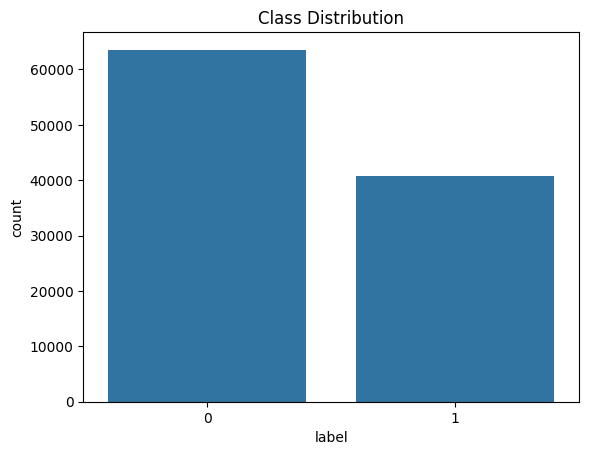

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
df = pd.read_csv('/content/dataset_sdn (2).csv')  # Replace with your dataset path

# Display basic information
print(df.info())
print(df.head())

# Visualize class distribution
sns.countplot(x='label', data=df)
plt.title('Class Distribution')
plt.show()


# **🧹 Step 2: Data Preprocessing**

In [ ]:
# Step 3: Drop Non-Numeric or Useless Columns
non_numeric_cols = df.select_dtypes(include=['object']).columns
print("Dropping non-numeric columns:", list(non_numeric_cols))
df.drop(columns=non_numeric_cols, inplace=True)

Dropping non-numeric columns: ['sourceIP', 'destinationIP', 'Protocol']


In [ ]:
# Step 4: Drop columns with too many missing values (>40%)
threshold = len(df) * 0.4
df = df.dropna(thresh=threshold, axis=1)

In [ ]:
# Step 5: Fill missing values
imputer = SimpleImputer(strategy='mean')
df = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)

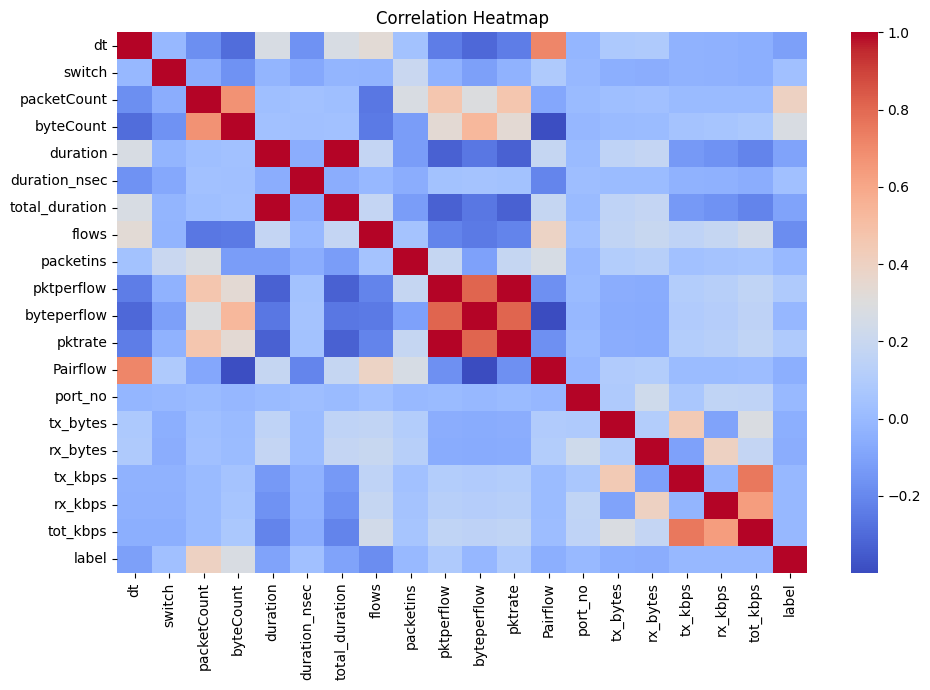

In [ ]:
# Step 6: Visualize Correlation Heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(pd.DataFrame(df).corr(), cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.tight_layout()
plt.show()

In [ ]:
# Step 7: Encode Labels (Assuming last column is label)
df['label'] = df['label'].astype(int)
X = df.drop('label', axis=1)
y = df['label']

In [ ]:
# Step 8: Balance Classes with SMOTE
smote = SMOTE(random_state=42)
X_balanced, y_balanced = smote.fit_resample(X, y)
print("Balanced class distribution:", np.bincount(y_balanced))

Balanced class distribution: [63561 63561]


In [ ]:
# Step 9: Scale Features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_balanced)

In [ ]:
# Step 10: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_balanced, test_size=0.2, stratify=y_balanced, random_state=42)
X_train_reshaped = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test_reshaped = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [ ]:
# Step 11: Define Model Functions
def create_cnn():
    model = Sequential()
    model.add(Conv1D(64, kernel_size=3, activation='relu', input_shape=(X_train_reshaped.shape[1], 1)))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

def create_lstm():
    model = Sequential()
    model.add(LSTM(64, input_shape=(X_train_reshaped.shape[1], 1)))
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

def create_cnn_lstm():
    model = Sequential()
    model.add(Conv1D(32, kernel_size=3, activation='relu', input_shape=(X_train_reshaped.shape[1], 1)))
    model.add(MaxPooling1D(pool_size=2))
    model.add(LSTM(64))
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model


In [ ]:
# Step 12: Train & Evaluate Model
def simulate_prevention(y_true, y_pred):
    df_result = pd.DataFrame({'Actual': y_true, 'Predicted': y_pred.flatten()})
    df_result['Action'] = df_result.apply(lambda row: 'Block' if row['Predicted'] == 1 else 'Allow', axis=1)

    # Simulate a firewall log for blocked traffic
    blocked = df_result[df_result['Action'] == 'Block']
    print("Simulated Firewall Actions (log):")
    for i, row in blocked.iterrows():
        print(f"[FIREWALL BLOCK] Connection #{i} flagged as DDoS - blocked.")

    # Simulate alert notification
    if not blocked.empty:
        print(f" ALERT: {len(blocked)} potential DDoS threats were blocked.")
    else:
        print(" No threats detected. All traffic allowed.")

    # Show prevention summary chart
    action_summary = df_result['Action'].value_counts()
    print(" Summary of Simulated Prevention Actions:")
    print(action_summary)

    plt.figure(figsize=(5, 4))
    sns.countplot(data=df_result, x='Action', palette='Set2')
    plt.title('Simulated Network Actions (Detection-Based Prevention)')
    plt.tight_layout()
    plt.show()

def train_and_evaluate(model_fn, model_name):
    print(f"\nTraining {model_name}...")
    model = model_fn()
    es = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    history = model.fit(X_train_reshaped, y_train, epochs=10, batch_size=64, validation_split=0.2, callbacks=[es], verbose=1)

    y_pred = (model.predict(X_test_reshaped) > 0.5).astype("int32")
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    fpr = cm[0][1] / (cm[0][0] + cm[0][1])

    print(f"\n{model_name} Evaluation")
    print("Accuracy:", acc)
    print("F1 Score:", f1)
    print("Recall:", recall)
    print("Precision:", precision)
    print("False Positive Rate:", fpr)
    print("\nClassification Report:\n", classification_report(y_test, y_pred))

    plt.figure()
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.show()

    plt.figure()
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title(f'{model_name} Accuracy over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.tight_layout()
    plt.show()

    plt.figure()
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(f'{model_name} Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.tight_layout()
    plt.show()
    simulate_prevention(y_test.to_numpy(), y_pred)


Training CNN...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
1272/1272 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8817 - loss: 0.2852 - val_accuracy: 0.9615 - val_loss: 0.0941
Epoch 2/10
1272/1272 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.9572 - loss: 0.1085 - val_accuracy: 0.9699 - val_loss: 0.0724
Epoch 3/10
1272/1272 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.9638 - loss: 0.0875 - val_accuracy: 0.9737 - val_loss: 0.0651
Epoch 4/10
1272/1272 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.9691 - loss: 0.0756 - val_accuracy: 0.9762 - val_loss: 0.0633
Epoch 5/10
1272/1272 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.9726 - loss: 0.0684 - val_accuracy: 0.9801 - val_loss: 0.0502
Epoch 6/10
1272/1272 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.9754 - loss: 0.0614 - val_accuracy: 0.9811 - val_loss: 0.0449
Epoch 7/10
1272/1272 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.9779 - loss: 0.0548 - val_accuracy: 0.9832 - val_loss: 0.0437
Epoch 8/10
1272/1272 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.9783 - loss: 0.0535 -

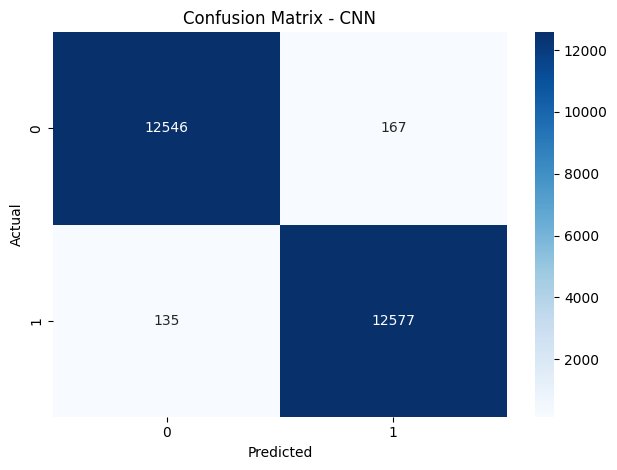

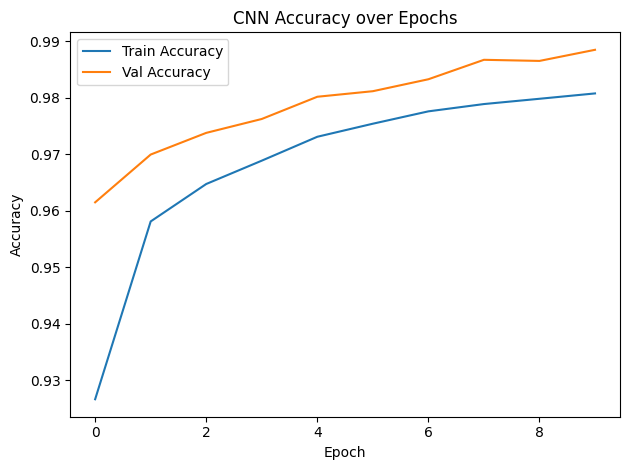

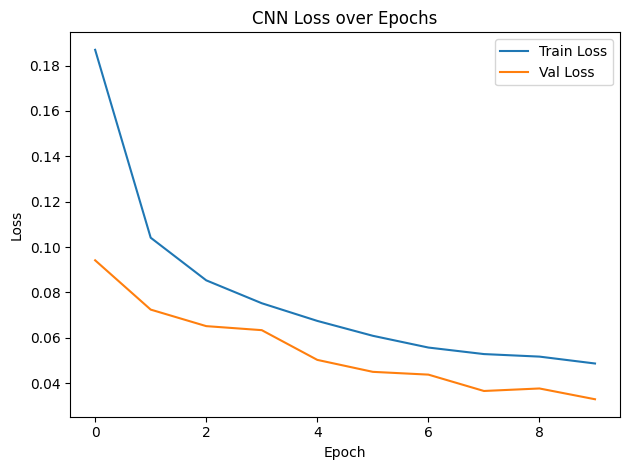

Streaming output truncated to the last 5000 lines.
[FIREWALL BLOCK] Connection #15514 flagged as DDoS - blocked.
[FIREWALL BLOCK] Connection #15516 flagged as DDoS - blocked.
[FIREWALL BLOCK] Connection #15517 flagged as DDoS - blocked.
[FIREWALL BLOCK] Connection #15518 flagged as DDoS - blocked.
[FIREWALL BLOCK] Connection #15522 flagged as DDoS - blocked.
[FIREWALL BLOCK] Connection #15523 flagged as DDoS - blocked.
[FIREWALL BLOCK] Connection #15524 flagged as DDoS - blocked.
[FIREWALL BLOCK] Connection #15525 flagged as DDoS - blocked.
[FIREWALL BLOCK] Connection #15526 flagged as DDoS - blocked.
[FIREWALL BLOCK] Connection #15528 flagged as DDoS - blocked.
[FIREWALL BLOCK] Connection #15530 flagged as DDoS - blocked.
[FIREWALL BLOCK] Connection #15532 flagged as DDoS - blocked.
[FIREWALL BLOCK] Connection #15533 flagged as DDoS - blocked.
[FIREWALL BLOCK] Connection #15534 flagged as DDoS - blocked.
[FIREWALL BLOCK] Connection #15535 flagged as DDoS - blocked.
[FIREWALL BLOCK] Co

<ipython-input-15-ae37b2c9597c>:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_result, x='Action', palette='Set2')


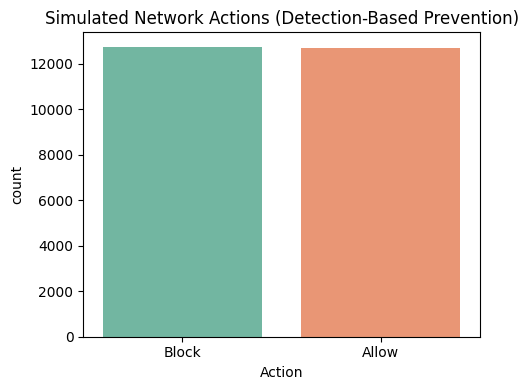

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Training LSTM...
Epoch 1/10
1272/1272 ━━━━━━━━━━━━━━━━━━━━ 24s 17ms/step - accuracy: 0.7057 - loss: 0.5362 - val_accuracy: 0.9160 - val_loss: 0.2217
Epoch 2/10
1272/1272 ━━━━━━━━━━━━━━━━━━━━ 19s 15ms/step - accuracy: 0.9212 - loss: 0.2141 - val_accuracy: 0.9367 - val_loss: 0.1667
Epoch 3/10
1272/1272 ━━━━━━━━━━━━━━━━━━━━ 22s 16ms/step - accuracy: 0.9323 - loss: 0.1736 - val_accuracy: 0.9454 - val_loss: 0.1346
Epoch 4/10
1272/1272 ━━━━━━━━━━━━━━━━━━━━ 19s 15ms/step - accuracy: 0.9422 - loss: 0.1381 - val_accuracy: 0.9589 - val_loss: 0.0998
Epoch 5/10
1272/1272 ━━━━━━━━━━━━━━━━━━━━ 21s 16ms/step - accuracy: 0.9543 - loss: 0.1143 - val_accuracy: 0.9659 - val_loss: 0.0894
Epoch 6/10
1272/1272 ━━━━━━━━━━━━━━━━━━━━ 42s 17ms/step - accuracy: 0.9628 - loss: 0.0934 - val_accuracy: 0.9722 - val_loss: 0.0708
Epoch 7/10
1272/1272 ━━━━━━━━━━━━━━━━━━━━ 20s 16ms/step - accuracy: 0.9684 - loss: 0.0814 - val_accuracy: 0.9794 - val_loss: 0.0570
Epoch 8/10
1272/1272 ━━━━━━━━━━━━━━━━━━━━ 20s 16ms/step - 

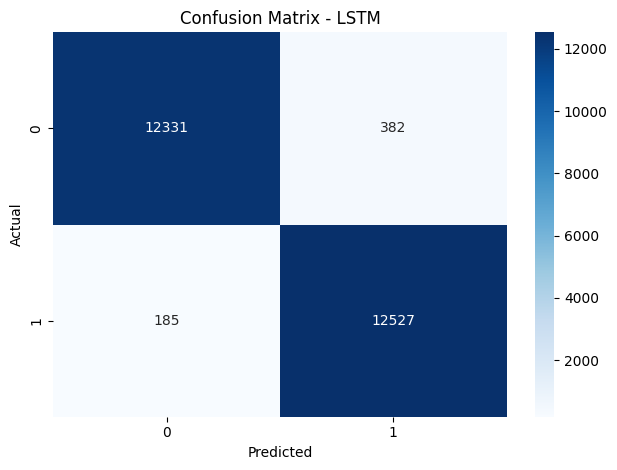

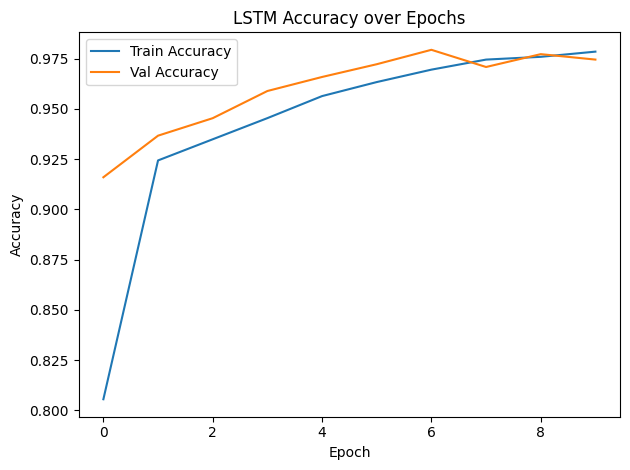

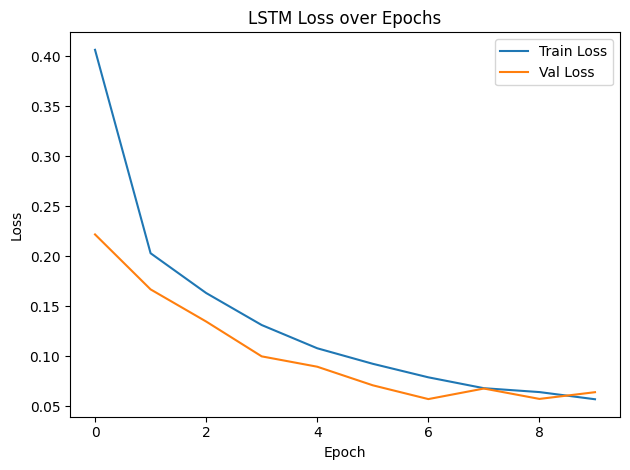

Streaming output truncated to the last 5000 lines.
[FIREWALL BLOCK] Connection #15606 flagged as DDoS - blocked.
[FIREWALL BLOCK] Connection #15607 flagged as DDoS - blocked.
[FIREWALL BLOCK] Connection #15608 flagged as DDoS - blocked.
[FIREWALL BLOCK] Connection #15614 flagged as DDoS - blocked.
[FIREWALL BLOCK] Connection #15615 flagged as DDoS - blocked.
[FIREWALL BLOCK] Connection #15617 flagged as DDoS - blocked.
[FIREWALL BLOCK] Connection #15618 flagged as DDoS - blocked.
[FIREWALL BLOCK] Connection #15620 flagged as DDoS - blocked.
[FIREWALL BLOCK] Connection #15621 flagged as DDoS - blocked.
[FIREWALL BLOCK] Connection #15625 flagged as DDoS - blocked.
[FIREWALL BLOCK] Connection #15626 flagged as DDoS - blocked.
[FIREWALL BLOCK] Connection #15628 flagged as DDoS - blocked.
[FIREWALL BLOCK] Connection #15630 flagged as DDoS - blocked.
[FIREWALL BLOCK] Connection #15631 flagged as DDoS - blocked.
[FIREWALL BLOCK] Connection #15634 flagged as DDoS - blocked.
[FIREWALL BLOCK] Co

<ipython-input-15-ae37b2c9597c>:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_result, x='Action', palette='Set2')


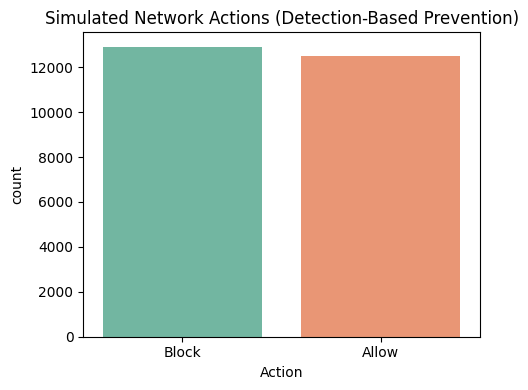

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Training CNN-LSTM...
Epoch 1/10
1272/1272 ━━━━━━━━━━━━━━━━━━━━ 17s 11ms/step - accuracy: 0.7640 - loss: 0.4620 - val_accuracy: 0.9339 - val_loss: 0.1659
Epoch 2/10
1272/1272 ━━━━━━━━━━━━━━━━━━━━ 15s 11ms/step - accuracy: 0.9304 - loss: 0.1733 - val_accuracy: 0.9517 - val_loss: 0.1178
Epoch 3/10
1272/1272 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - accuracy: 0.9490 - loss: 0.1280 - val_accuracy: 0.9639 - val_loss: 0.0911
Epoch 4/10
1272/1272 ━━━━━━━━━━━━━━━━━━━━ 21s 11ms/step - accuracy: 0.9595 - loss: 0.1028 - val_accuracy: 0.9726 - val_loss: 0.0742
Epoch 5/10
1272/1272 ━━━━━━━━━━━━━━━━━━━━ 16s 13ms/step - accuracy: 0.9644 - loss: 0.0879 - val_accuracy: 0.9717 - val_loss: 0.0712
Epoch 6/10
1272/1272 ━━━━━━━━━━━━━━━━━━━━ 15s 12ms/step - accuracy: 0.9711 - loss: 0.0722 - val_accuracy: 0.9757 - val_loss: 0.0621
Epoch 7/10
1272/1272 ━━━━━━━━━━━━━━━━━━━━ 19s 15ms/step - accuracy: 0.9759 - loss: 0.0621 - val_accuracy: 0.9801 - val_loss: 0.0542
Epoch 8/10
1272/1272 ━━━━━━━━━━━━━━━━━━━━ 20s 14ms/ste

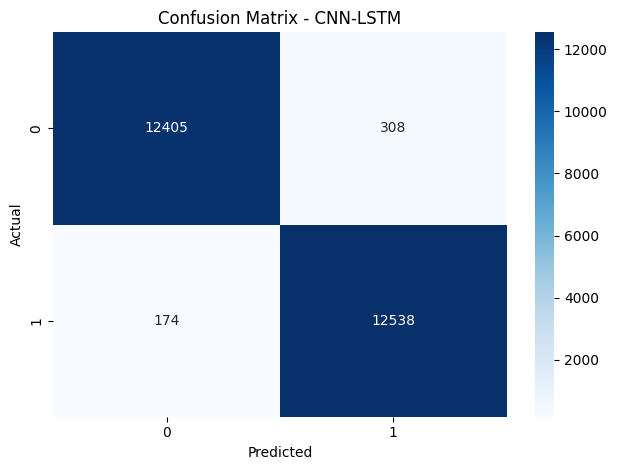

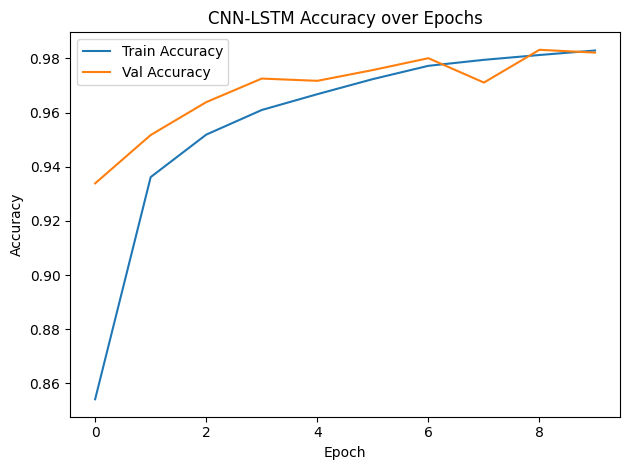

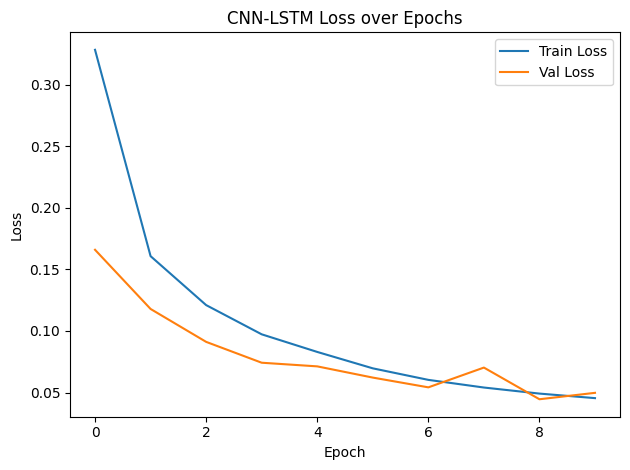

Streaming output truncated to the last 5000 lines.
[FIREWALL BLOCK] Connection #15559 flagged as DDoS - blocked.
[FIREWALL BLOCK] Connection #15560 flagged as DDoS - blocked.
[FIREWALL BLOCK] Connection #15562 flagged as DDoS - blocked.
[FIREWALL BLOCK] Connection #15563 flagged as DDoS - blocked.
[FIREWALL BLOCK] Connection #15565 flagged as DDoS - blocked.
[FIREWALL BLOCK] Connection #15566 flagged as DDoS - blocked.
[FIREWALL BLOCK] Connection #15567 flagged as DDoS - blocked.
[FIREWALL BLOCK] Connection #15569 flagged as DDoS - blocked.
[FIREWALL BLOCK] Connection #15571 flagged as DDoS - blocked.
[FIREWALL BLOCK] Connection #15572 flagged as DDoS - blocked.
[FIREWALL BLOCK] Connection #15574 flagged as DDoS - blocked.
[FIREWALL BLOCK] Connection #15575 flagged as DDoS - blocked.
[FIREWALL BLOCK] Connection #15577 flagged as DDoS - blocked.
[FIREWALL BLOCK] Connection #15578 flagged as DDoS - blocked.
[FIREWALL BLOCK] Connection #15579 flagged as DDoS - blocked.
[FIREWALL BLOCK] Co

<ipython-input-15-ae37b2c9597c>:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_result, x='Action', palette='Set2')


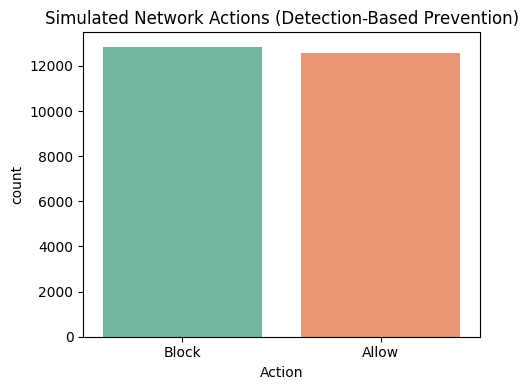

In [ ]:
# Step 13: Run All Models
train_and_evaluate(create_cnn, "CNN")
train_and_evaluate(create_lstm, "LSTM")
train_and_evaluate(create_cnn_lstm, "CNN-LSTM")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


795/795 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
795/795 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step
795/795 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


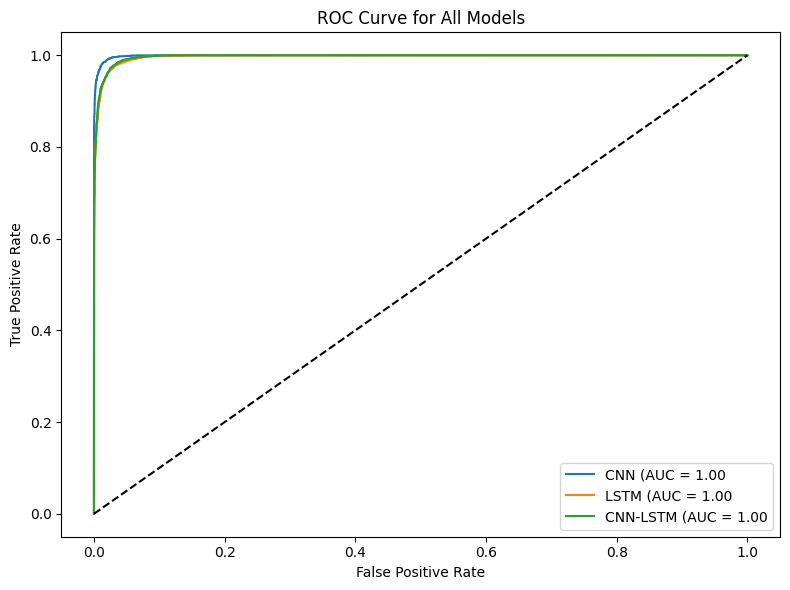

In [ ]:
# Step 15: Additional Visualizations (ROC & Comparison)
from sklearn.metrics import roc_curve, auc

# Helper to plot ROC
models = [create_cnn(), create_lstm(), create_cnn_lstm()]
model_names = ["CNN", "LSTM", "CNN-LSTM"]

plt.figure(figsize=(8, 6))
for model, name in zip(models, model_names):
    model.fit(X_train_reshaped, y_train, epochs=5, batch_size=64, verbose=0)
    y_proba = model.predict(X_test_reshaped).ravel()
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f}')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for All Models')
plt.legend()
plt.tight_layout()
plt.show()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
<ipython-input-18-03d9ac73cc6e>:8: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(history_dict.values(), labels=history_dict.keys())


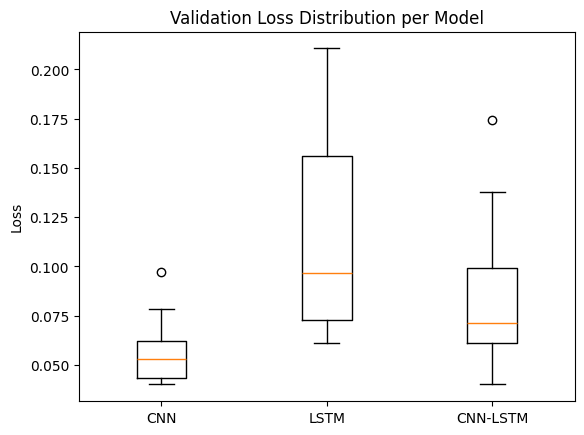

In [ ]:
# Step 16: Boxplot of Loss Values (simulate overfitting insight)
history_dict = {}
for fn, name in zip([create_cnn, create_lstm, create_cnn_lstm], model_names):
    model = fn()
    h = model.fit(X_train_reshaped, y_train, epochs=10, batch_size=64, validation_split=0.2, verbose=0)
    history_dict[name] = h.history['val_loss']

plt.boxplot(history_dict.values(), labels=history_dict.keys())
plt.title('Validation Loss Distribution per Model')
plt.ylabel('Loss')
plt.show()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


795/795 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


795/795 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


795/795 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


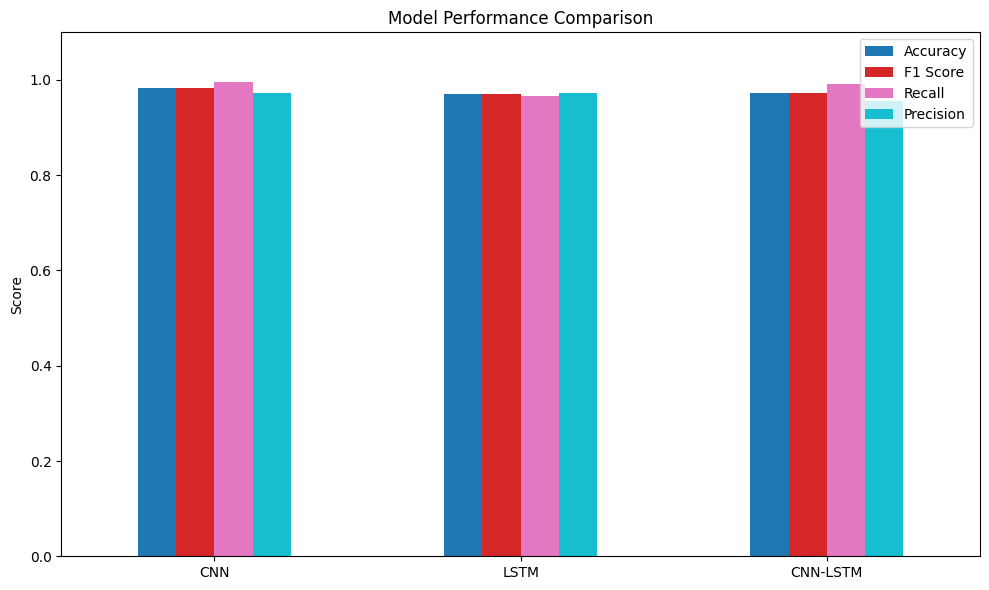

In [ ]:
# Step 17: Bar Chart Comparing Accuracy, F1, Recall, Precision
results = {
    "CNN": [], "LSTM": [], "CNN-LSTM": []
}

for fn, name in zip([create_cnn, create_lstm, create_cnn_lstm], model_names):
    model = fn()
    model.fit(X_train_reshaped, y_train, epochs=5, batch_size=64, verbose=0)
    y_pred = (model.predict(X_test_reshaped) > 0.5).astype("int32")
    results[name] = [
        accuracy_score(y_test, y_pred),
        f1_score(y_test, y_pred),
        recall_score(y_test, y_pred),
        precision_score(y_test, y_pred)
    ]

df_compare = pd.DataFrame(results, index=["Accuracy", "F1 Score", "Recall", "Precision"])
df_compare.T.plot(kind='bar', figsize=(10, 6), colormap='tab10')
plt.title("Model Performance Comparison")
plt.ylabel("Score")
plt.ylim(0, 1.1)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()